In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from models.graph_water_transformer_cov_no_lstm import graph_water_transformer_cov_gate_predictor_no_lstm

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1


import random

random.seed(10)
print(random.random())

2023-08-12 12:27:52.291260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 12:27:53.768057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.5714025946899135


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [5]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [6]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

In [7]:
input_shape = train_cov.shape[1:]

In [10]:
gate_predictor, GCNConv = graph_water_transformer_cov_gate_predictor_no_lstm(input_shape=input_shape,
                                                                       gcn1=gcn_unit1,
                                                                       gcn2=gcn_unit2,
                                                                       num_transformer_blocks=num_transformer_blocks,
                                                                       head_size=head_size,
                                                                       num_heads=num_heads,
                                                                       ff_dim=ff_dim, 
                                                                       atte_reg=atte_reg, 
                                                                       l1_reg=l1_reg, 
                                                                       l2_reg=l2_reg, 
                                                                       dropout=dropout,
                                                                       masked_value=masked_value,
                                                                       gate_min=gate_min,
                                                                       gate_max=gate_max
                                                                      )
gate_predictor._name = "gate_predictor"
# gate_predictor.summary()

In [11]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [12]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [13]:
inputs_cov = Input(shape=(96, 12), name='input_cov')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor([inputs_cov, inputs_tws, inputs_adj])  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_cov[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_cov[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs_cov = layers.Concatenate(axis=1)([inputs_cov[:, :n_hours, :], replaced_future_gate_pump])

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_cov, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-12 12:28:35.520798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-12 12:28:36.945146: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0c356d5a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-12 12:28:36.945199: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-12 12:28:36.955098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-12 12:28:37.343026: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 2.07997, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 29s - loss: 0.4679 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2215 - val_loss: 4.1635 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0800 - 29s/epoch - 191ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.07997 to 1.92558, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.4175 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2071 - val_loss: 3.8542 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9256 - 13s/epoch - 86ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss improved from 1.92558 to 1.86359, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.4100 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2036 - val_loss: 3.7297 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.8636 - 13s/epoch - 87ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 1.86359 to 1.85091, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.4067 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2021 - val_loss: 3.7042 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.8509 - 13s/epoch - 87ms/ste

Epoch 29/700

Epoch 29: val_ws_predictor_loss did not improve from 1.55025
151/151 - 13s - loss: 0.3819 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.1145 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5569 - 13s/epoch - 85ms/step
Epoch 30/700

Epoch 30: val_ws_predictor_loss did not improve from 1.55025
151/151 - 13s - loss: 0.3819 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.1044 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5519 - 13s/epoch - 85ms/step
Epoch 31/700

Epoch 31: val_ws_predictor_loss did not improve from 1.55025
151/151 - 13s - loss: 0.3835 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1913 - val_loss: 3.1212 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5600 - 13s/epoch - 86ms/step
Epoch 32/700

Epoch 32: val_ws_predictor_loss did not improve from 1.55025
151/151 - 13s - loss: 0.3821 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.19

Epoch 57/700

Epoch 57: val_ws_predictor_loss improved from 1.48573 to 1.48211, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.3806 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9647 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4821 - 13s/epoch - 87ms/step
Epoch 58/700

Epoch 58: val_ws_predictor_loss did not improve from 1.48211
151/151 - 13s - loss: 0.3805 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9851 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4924 - 13s/epoch - 85ms/step
Epoch 59/700

Epoch 59: val_ws_predictor_loss improved from 1.48211 to 1.47936, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.3805 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9591 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4794 - 13s/epoch - 86ms/step
Epoch 60/700

Epoch 60: val_ws_predictor_

Epoch 86/700

Epoch 86: val_ws_predictor_loss did not improve from 1.46915
151/151 - 13s - loss: 0.3806 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9541 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4769 - 13s/epoch - 86ms/step
Epoch 87/700

Epoch 87: val_ws_predictor_loss did not improve from 1.46915
151/151 - 13s - loss: 0.3803 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1900 - val_loss: 2.9441 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4719 - 13s/epoch - 86ms/step
Epoch 88/700

Epoch 88: val_ws_predictor_loss did not improve from 1.46915
151/151 - 13s - loss: 0.3803 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1900 - val_loss: 2.9477 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4737 - 13s/epoch - 86ms/step
Epoch 89/700

Epoch 89: val_ws_predictor_loss did not improve from 1.46915
151/151 - 13s - loss: 0.3803 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.19

Epoch 115/700

Epoch 115: val_ws_predictor_loss did not improve from 1.45838
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9342 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4670 - 13s/epoch - 85ms/step
Epoch 116/700

Epoch 116: val_ws_predictor_loss did not improve from 1.45838
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9298 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4648 - 13s/epoch - 85ms/step
Epoch 117/700

Epoch 117: val_ws_predictor_loss did not improve from 1.45838
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9333 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4666 - 13s/epoch - 86ms/step
Epoch 118/700

Epoch 118: val_ws_predictor_loss did not improve from 1.45838
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_lo

151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9238 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4618 - 13s/epoch - 85ms/step
Epoch 145/700

Epoch 145: val_ws_predictor_loss did not improve from 1.45838
151/151 - 13s - loss: 0.3798 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9191 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4595 - 13s/epoch - 85ms/step
Epoch 146/700

Epoch 146: val_ws_predictor_loss improved from 1.45838 to 1.45458, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.3797 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9093 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4546 - 13s/epoch - 86ms/step
Epoch 147/700

Epoch 147: val_ws_predictor_loss did not improve from 1.45458
151/151 - 13s - loss: 0.3797 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val

151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9196 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4597 - 13s/epoch - 85ms/step
Epoch 174/700

Epoch 174: val_ws_predictor_loss improved from 1.45458 to 1.45082, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.3798 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9018 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4508 - 13s/epoch - 86ms/step
Epoch 175/700

Epoch 175: val_ws_predictor_loss did not improve from 1.45082
151/151 - 13s - loss: 0.3797 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9112 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4555 - 13s/epoch - 85ms/step
Epoch 176/700

Epoch 176: val_ws_predictor_loss did not improve from 1.45082
151/151 - 13s - loss: 0.3797 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val

Epoch 202/700

Epoch 202: val_ws_predictor_loss improved from 1.44836 to 1.44468, saving model to ../saved_models/gtnp_gtnp_13_no_lstm.h5
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.8895 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4447 - 13s/epoch - 86ms/step
Epoch 203/700

Epoch 203: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9068 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4534 - 13s/epoch - 85ms/step
Epoch 204/700

Epoch 204: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.8995 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4497 - 13s/epoch - 85ms/step
Epoch 205/700

Epoch 205: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - los

Epoch 231/700

Epoch 231: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9093 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4546 - 13s/epoch - 85ms/step
Epoch 232/700

Epoch 232: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9098 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4549 - 13s/epoch - 85ms/step
Epoch 233/700

Epoch 233: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9163 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4581 - 13s/epoch - 85ms/step
Epoch 234/700

Epoch 234: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_lo

151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9115 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4557 - 13s/epoch - 85ms/step
Epoch 261/700

Epoch 261: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9126 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4563 - 13s/epoch - 84ms/step
Epoch 262/700

Epoch 262: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9190 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4594 - 13s/epoch - 85ms/step
Epoch 263/700

Epoch 263: val_ws_predictor_loss did not improve from 1.44468
151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9194 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.8997 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4496 - 13s/epoch - 85ms/step
Epoch 290/700

Epoch 290: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3842 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1916 - val_loss: 2.9172 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4586 - 13s/epoch - 85ms/step
Epoch 291/700

Epoch 291: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9204 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4601 - 13s/epoch - 85ms/step
Epoch 292/700

Epoch 292: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3794 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9187 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

Epoch 319/700

Epoch 319: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9114 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4557 - 13s/epoch - 85ms/step
Epoch 320/700

Epoch 320: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9178 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4588 - 13s/epoch - 85ms/step
Epoch 321/700

Epoch 321: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9183 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4591 - 13s/epoch - 85ms/step
Epoch 322/700

Epoch 322: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_lo

151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9233 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4616 - 13s/epoch - 85ms/step
Epoch 349/700

Epoch 349: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9179 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4589 - 13s/epoch - 85ms/step
Epoch 350/700

Epoch 350: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9331 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4665 - 13s/epoch - 85ms/step
Epoch 351/700

Epoch 351: val_ws_predictor_loss did not improve from 1.44428
151/151 - 13s - loss: 0.3793 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1896 - val_loss: 2.9189 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

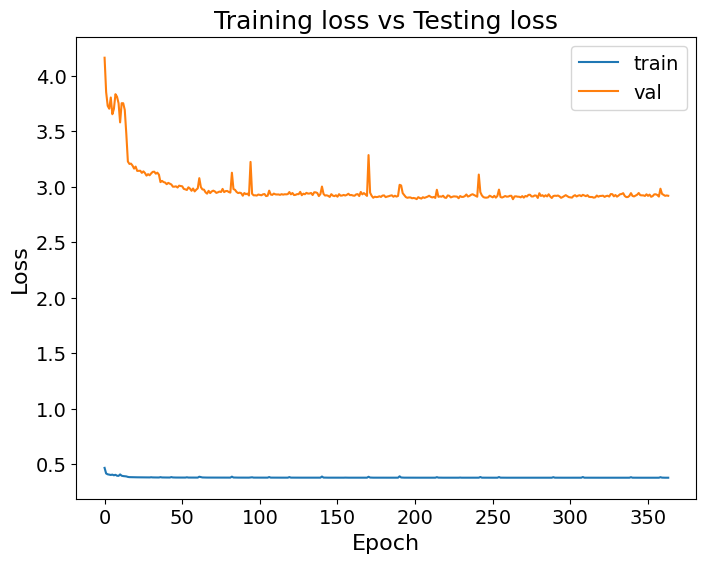

In [14]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/gtnp_gtnp_13_no_lstm.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_cov, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_cov, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,
                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [15]:
saved_model = load_model('../saved_models/gtnp_gtnp_13_no_lstm.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [16]:
gate_pump_pred, ws_pred = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)

603/603 [==============================] - 4s 6ms/step
(19268, 24, 7)
(19268, 96)


#### ws pred, gate pred

In [17]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [18]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [19]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [20]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 35, 28, 47, 64
S1, S25A, S25B, S26 areas: 4.3475, 3.4302, 6, 9.2427
TOTAL time steps: 174; TOTAL areas: 22.565
--------------------------------------------------


In [21]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1, 1, 2, 2
S1, S25A, S25B, S26 areas: 0.0924, 0.0659, 0, 0.1866
TOTAL time steps: 6; TOTAL areas: 0.499
--------------------------------------------------


In [22]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 7804, areas: 1217.8468780517578


### Lower threshold

In [23]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 329, 125, 37, 136
S1, S25A, S25B, S26 areas: -56.7439, -17.5528, -3.9107, -19.8735:
TOTAL time steps: 627; TOTAL areas: -98.0809
--------------------------------------------------


In [24]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [25]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 13849, areas: 2339.254786713831


In [26]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, t1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, t1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, t1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5166, areas: 1465.099992136471
time steps: 5575, areas: 1570.7175889443388
time steps: 627, areas: 98.08094071313099
